# Simulating and Predicting the 2025 NBA Finals

### 1. Import Required Libraries 

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score

### 2. Load and Preprocess Data

In [129]:
df = pd.read_csv("NBA_2025_Playoff_Series_with_metrics.csv")
df.head()

,Visitor/Neutral,PTS,Win,Home/Neutral,PTS.1,Win.1,Visitor Seed,Home Seed,Year,Visitor_id,...,Home win_pct,Home off_rtg,Home def_rtg,Home net_rtg,Home pace,Home efg_pct,Home ts_pct,Home tov_pct,Home orb_pct,Home drb_pct
0,Indiana Pacers,79,1,Philadelphia 76ers,78,0,8,1,2001,1.610613e+09,...,0.293,111.0,117.3,-6.3,98.13,0.527,0.563,0.138,0.279,0.678
1,Dallas Mavericks,86,0,Utah Jazz,88,1,5,4,2001,1.610613e+09,...,0.207,110.2,119.4,-9.2,100.85,0.533,0.568,0.170,0.311,0.705
2,Minnesota Timberwolves,82,0,San Antonio Spurs,87,1,8,1,2001,1.610613e+09,...,0.415,113.5,116.3,-2.8,100.08,0.544,0.575,0.138,0.278,0.690
3,Charlotte Hornets,106,1,Miami Heat,80,0,6,3,2001,1.610613e+09,...,0.451,112.4,112.0,0.4,97.08,0.544,0.576,0.138,0.263,0.724
4,Toronto Raptors,85,0,New York Knicks,92,1,5,4,2001,1.610613e+09,...,0.622,117.3,113.3,4.0,97.64,0.556,0.589,0.134,0.305,0.710


In [130]:
# Check for missing values
print("Missing Values:")
missing_values = df.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

Missing Values:
Series([], dtype: int64)


In [131]:
# Remove unnecessary columns
df.drop(['Win','PTS','PTS.1','Visitor_id','Home_id'], axis=1, inplace=True)

# Encode categorical variables
feature_data = df.drop(columns=['Home/Neutral','Visitor/Neutral', 'Year'], errors='ignore')
encoded = pd.get_dummies(feature_data, drop_first=True)

# Change "Win" to boolean
if df["Win.1"].dtype != "bool":
    df["Win.1"] = df["Win.1"].astype(bool)
    df["Win.1"] = df["Win.1"].map({True: 1, False: 0})

In [132]:
print(df[pd.isnull(df["Win.1"])])
print(df.head())

Empty DataFrame
Columns: [Visitor/Neutral, Home/Neutral, Win.1, Visitor Seed, Home Seed, Year, Visitor win_pct, Visitor off_rtg, Visitor def_rtg, Visitor net_rtg, Visitor pace, Visitor efg_pct, Visitor ts_pct, Visitor tov_pct, Visitor orb_pct, Visitor drb_pct, Home win_pct, Home off_rtg, Home def_rtg, Home net_rtg, Home pace, Home efg_pct, Home ts_pct, Home tov_pct, Home orb_pct, Home drb_pct]
Index: []

[0 rows x 26 columns]
          Visitor/Neutral        Home/Neutral  Win.1  Visitor Seed  Home Seed  \
0          Indiana Pacers  Philadelphia 76ers      0             8          1   
1        Dallas Mavericks           Utah Jazz      1             5          4   
2  Minnesota Timberwolves   San Antonio Spurs      1             8          1   
3       Charlotte Hornets          Miami Heat      0             6          3   
4         Toronto Raptors     New York Knicks      1             5          4   

   Year  Visitor win_pct  Visitor off_rtg  Visitor def_rtg  Visitor net_rtg  \
0  2

### 3. Exploratory Data Analysis

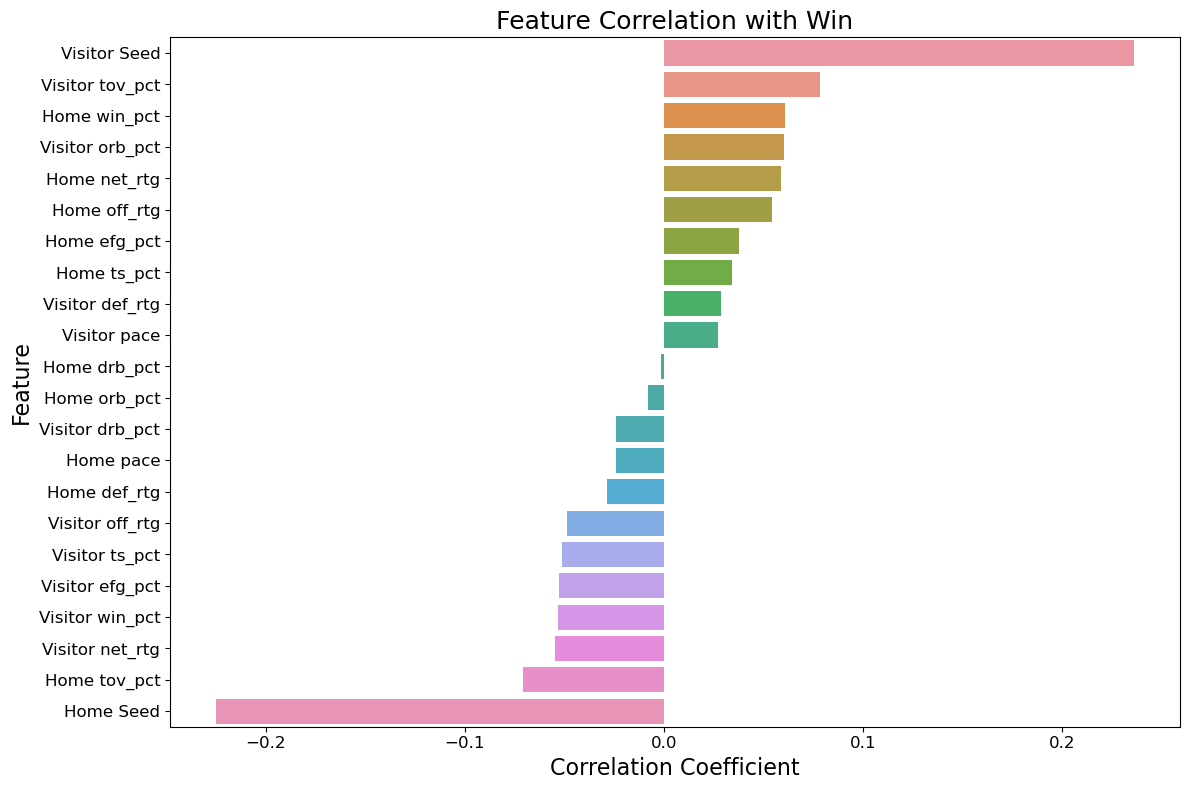

In [133]:
# Correlation between features and target
corr = encoded.corr()
corr_target = corr['Win.1'].drop('Win.1').sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=corr_target.values, y=corr_target.index, orient='h')
plt.title('Feature Correlation with Win', fontsize=18)
plt.xlabel('Correlation Coefficient', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

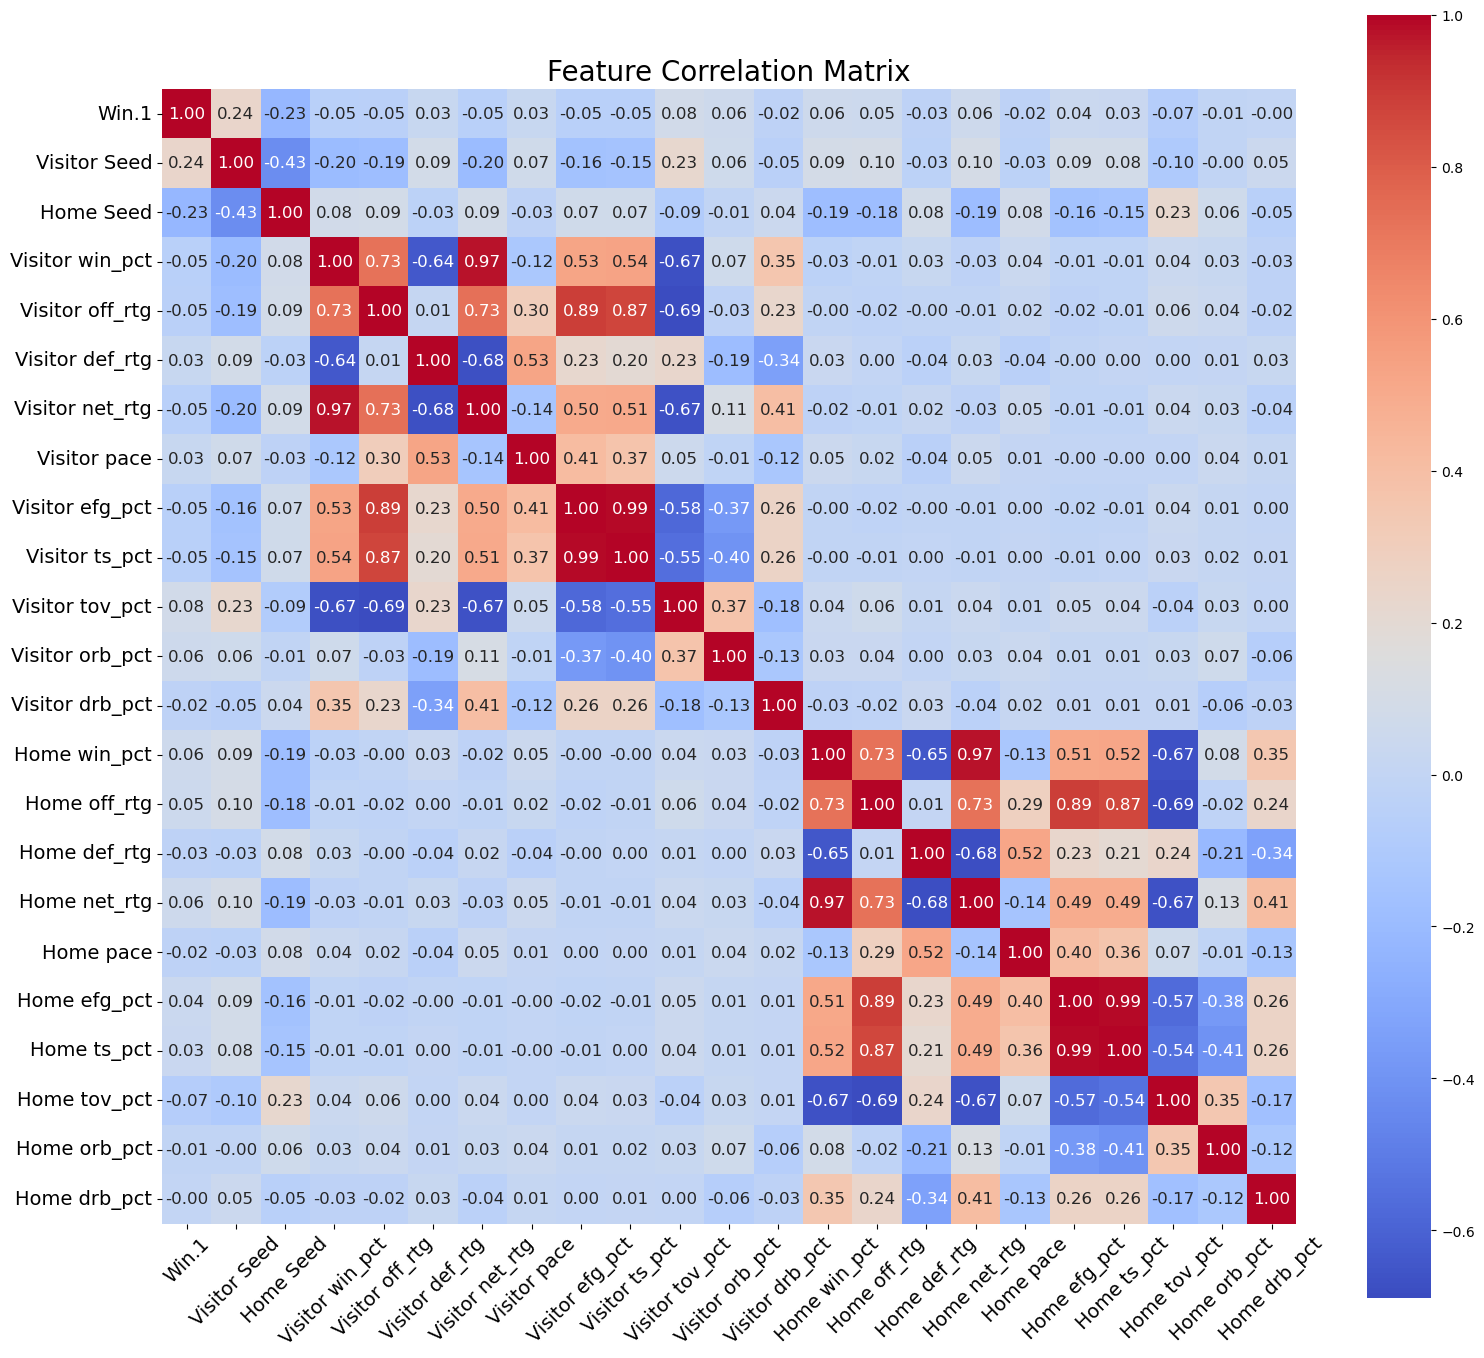

In [134]:
# Correlation between features only
plt.figure(figsize=(16, 14))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            annot_kws={'size':12})
plt.title('Feature Correlation Matrix', fontsize=20)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14, rotation=0)
plt.tight_layout()
plt.show()

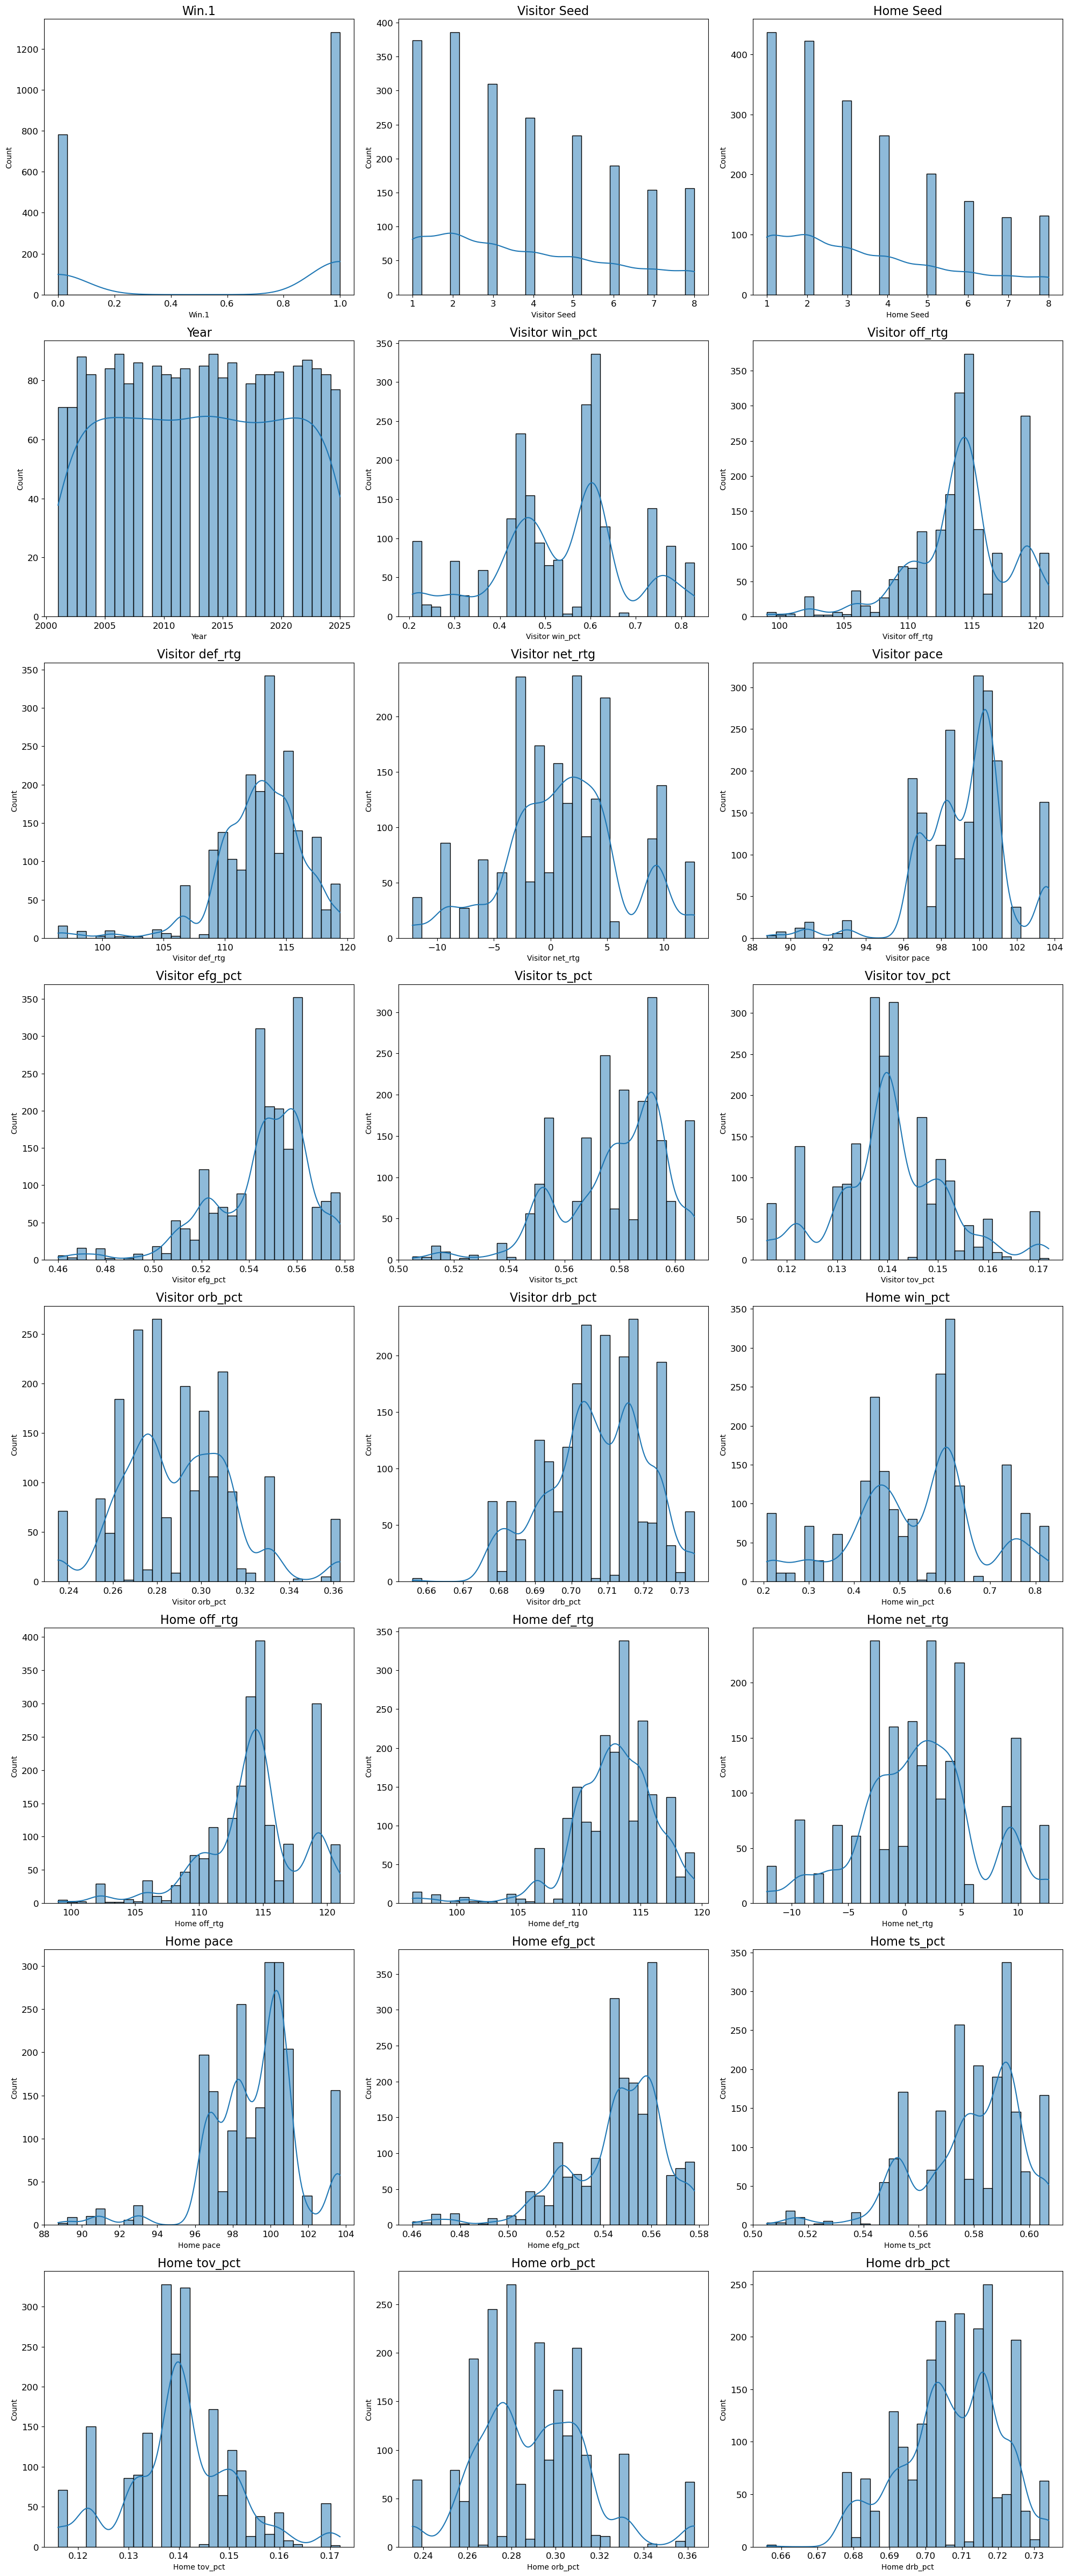

In [135]:
# Distribution of individual features
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_per_row = 3
n = len(num_cols)
rows = (n + cols_per_row - 1) // cols_per_row
plt.figure(figsize=(20, 6 * rows))
for i, col in enumerate(num_cols):
    ax = plt.subplot(rows, cols_per_row, i + 1)
    sns.histplot(df[col], bins=30, kde=True)
    ax.set_title(col, fontsize=16)
    ax.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

### 4. Model Building and Training

In [136]:
# Separate features and target
x = encoded.drop('Win.1', axis = 1)
y = encoded['Win.1']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Initialize and train
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

print("Train Accuracy:", model.score(X_train, y_train))
y_pred = model.predict(X_test)
print(f'Test Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Train Accuracy: 0.8007268322228952
Test Accuracy: 0.59080


### 5. Model Tuning and Evaluation

In [137]:
# Hyperparameter Tuning (GridSearchCV)
param_grid = {
'n_estimators': [50, 100, 200],
'max_depth': [None, 10, 20],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4],
'max_features': ['sqrt', 'log2'],
'ccp_alpha': [0, 0.01, 0.1] }

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

# Train the model with the best hyperparameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Cross-Validation to evaluate stability
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

Best Hyperparameters: {'ccp_alpha': 0.01, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Cross-Validation Scores: [0.63141994 0.63333333 0.63333333 0.63333333 0.63030303]
Mean CV Accuracy: 0.6323445939760138


In [138]:
# Fine tine a new model to reduce overfitting
model_new = RandomForestClassifier(
n_estimators = 75,
max_depth = 7,
min_samples_split=6,
min_samples_leaf=7,
ccp_alpha=0,
max_features='sqrt',
random_state=42
)

# Evaluate
model_new.fit(X_train, y_train)
print("Train Accuracy:", model_new.score(X_train, y_train))
y_pred = model_new.predict(X_test)
print(f'Test Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Train Accuracy: 0.7141126589945488
Test Accuracy: 0.61259


### 6. Create and Run Simulation

In [139]:
def simulate_finals(model, stats_a, stats_b, n_simulations=10000):
    probs = []
    
    for _ in range(n_simulations):

        # Combine stats into one feature vector
        features = np.hstack((stats_a, stats_b)).reshape(1, -1)
        
        # Probability that team A wins
        prob = model.predict_proba(features)[0][1]
        probs.append(prob)
        
    return np.mean(probs)

In [142]:
# Extract team stats
feature_cols = x.columns.tolist()

mask_okc_row    = (df2025['Home/Neutral'] == 'Oklahoma City Thunder') & (df2025['Year'] == 2025)
mask_pacers_row = (df2025['Visitor/Neutral'] == 'Indiana Pacers') & (df2025['Year'] == 2025)
stats_okc    = encoded.loc[mask_okc_row, feature_cols].iloc[0].values
stats_pacers = encoded.loc[mask_pacers_row, feature_cols].iloc[0].values

# Run Monte Carlo simulation
prob_okc   = simulate_finals(model, stats_okc, stats_pacers)
prob_pacers = 1 - prob_okc

print(f"Oklahoma City Thunder win probability: {prob_okc:.2%}")
print(f"Indiana Pacers win probability: {prob_pacers:.2%}")

/Users/tejgangupantula/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ValueError: X has 44 features, but RandomForestClassifier is expecting 22 features as input.